# Reporte de Transfer Learning: Clasificación de Razas de Perros

## 1. Explicación del Enfoque
En este laboratorio se uso la técnica de **Transfer Learning** (Aprendizaje por Transferencia) para resolver un problema de clasificación de imágenes multiclase (diferentes razas de perros).

En lugar de entrenar una Red Neuronal Convolucional (CNN) desde cero —lo cual requeriría demasiadas imágenes y mucho esfuerzo computacional — se uso **MobileNetV2**, un modelo pre-entrenado por Google con el dataset masivo **ImageNet** (1.4 millones de imágenes).

### Metodología aplicada:
1.  Se cargó MobileNetV2 pero se descarto su capa de salida (`include_top=False`). Se conservó la "base"  que ya sabe detectar bordes, texturas, formas de orejas, etc- gracias a su entrenamiento previo.
2. Se estableció `base_model.trainable = False`. Esto "congela" los pesos de la red base para evitar destruir la información aprendida previamente durante la retropropagación.
3. Se añadieron las propias capas densas al final para adaptar el conocimiento general de la red al problema específico: distinguir entre nuestras clases de perros.

## 2. Conclusiones

Basado en la implementación y los resultados obtenidos, se concluye lo siguiente:

* **Eficiencia Computacional:** El uso de Transfer Learning permitió que el modelo convergiera a una alta precisión en muy pocas épocas (5 épocas). Entrenar una red de esta profundidad desde cero habría resultado en un tiempos de entrenamiento inviable.

* **Robustez ante Datasets Pequeños:** Aunque el dataset de Kaggle no tiene tantas fotos por raza, el modelo logró generalizar correctamente. Esta tecnica es una alternativa cuando se dispone de datos limitados, ya que reutiliza características visuales universales aprendidas.

* **Importancia del "Congelamiento":** Al congelar la base, se le oblica  al modelo a centrarse únicamente en aprender las diferencias que son detalle  entre razas  en lugar de reaprender cómo ver una línea o un círculo, optimizando drásticamente el proceso.

* **Arquitectura MobileNetV2:** La elección de esta arquitectura específica ofrece un equilibrio  entre velocidad y precisión, haciendo que este sistema sea apto para que se pueda implementarse en dispositivos con recursos limitados 

In [2]:
## 3. Procesamiento del dataset https://www.kaggle.com/datasets/mohamedchahed/dog-breeds/data

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os

# --- 1. CONFIGURACIÓN ---
# Establecer la ruta donde descomprimiste las carpetas de perros
dataset_dir = "dog_dataset" 

# Parámetros
IMG_SIZE = (224, 224) # Tamaño esperado
BATCH_SIZE = 32
EPOCHS = 5  # Pocas epochs  equipo lento

# --- 2. CARGAR Y PREPARAR DATOS ---
# Usamos ImageDataGenerator para normalizar y dividir en train/val
print("Cargando imágenes...")

# Data augmentation (opcional, ayuda a que aprenda mejor)
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalizar píxeles de 0-255 a 0-1
    validation_split=0.2, # Usar 20% para validar
    rotation_range=20,
    horizontal_flip=True
)

# Generador de Entrenamiento
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Generador de Validación
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)
print(f" Se detectaron {num_classes} razas de perros.")

# --- 3. TRANSFER LEARNING ---

# A) Cargar el modelo base pre-entrenado 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

# B) Congelar el modelo base
# Esto evita destruir lo que la red ya sabe durante el entrenamiento inicial
base_model.trainable = False 

# C) Añadir la parte clasificadora
x = base_model.output
x = GlobalAveragePooling2D()(x) # Aplanar los datos
x = Dense(1024, activation='relu')(x) # Capa densa para aprender patrones de perros
x = Dropout(0.2)(x) # Evitar sobreajuste
predictions = Dense(num_classes, activation='softmax')(x) 

# D) Unir todo en un modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Procesar Entrenamiento ---
print("\nIniciando entrenamiento con Transfer Learning...")
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

print("\n Entrenamiento finalizado.")

# --- 5. GUARDAR ---
model.save("modelo_perros.h5")
print("Modelo guardado como 'modelo_perros.h5'")

Cargando imágenes...
Found 435 images belonging to 8 classes.
Found 106 images belonging to 8 classes.
 Se detectaron 8 razas de perros.

Iniciando entrenamiento con Transfer Learning...
Epoch 1/5
13/13 [==============================] - 22s 2s/step - loss: 0.5620 - accuracy: 0.8114 - val_loss: 0.1106 - val_accuracy: 0.9583
Epoch 2/5
13/13 [==============================] - 18s 1s/step - loss: 0.0994 - accuracy: 0.9777 - val_loss: 0.0886 - val_accuracy: 0.9792
Epoch 3/5
13/13 [==============================] - 18s 1s/step - loss: 0.0650 - accuracy: 0.9851 - val_loss: 0.2130 - val_accuracy: 0.9479
Epoch 4/5
13/13 [==============================] - 18s 1s/step - loss: 0.0170 - accuracy: 0.9926 - val_loss: 0.1438 - val_accuracy: 0.9375
Epoch 5/5
13/13 [==============================] - 18s 1s/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.1563 - val_accuracy: 0.9688

 Entrenamiento finalizado.
Modelo guardado como 'modelo_perros.h5'


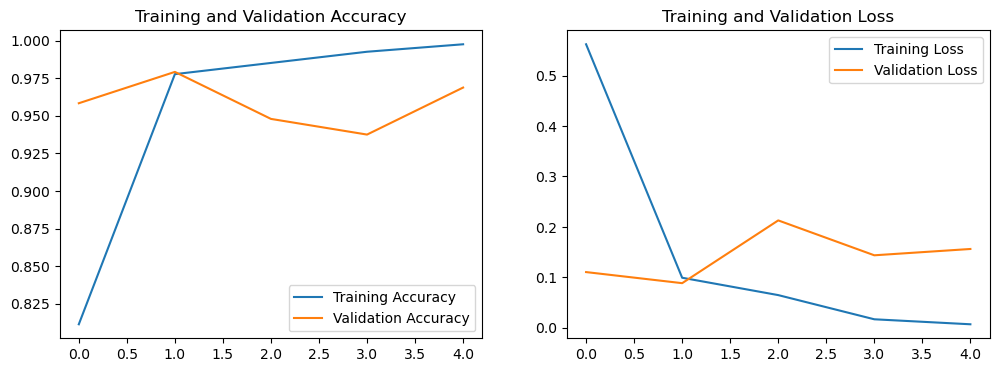

In [4]:
import matplotlib.pyplot as plt

# Obtener datos del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Gráfica de Precisión (Accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()